# Merging Galaxy Classification

This project builds a classification model to determine whether a galaxy is undergoing a merger.

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score
import time
import matplotlib.pyplot as plt

## Data Cleaning and Preprocessing

### Dataset Loading

In [5]:
path_morphology = r"C:/Users/migue/OneDrive/Documentos/datasets galaxias/morphology_catalogue.csv"
data_morph = pd.read_csv(path_morphology)

path_physical = r"C:/Users/migue/OneDrive/Documentos/datasets galaxias/useful_physical_measurements.parquet"
data_phys = pd.read_parquet(path_physical)


We select the variables that are most relevant for inferring whether galaxies are merging, including both physical properties and merging-related morphological indicators.

In [6]:
variables_morph = ['object_id', 'mumax_minus_mag', 'mag_segmentation', 'ellipticity', 'kron_radius', 'smooth-or-featured_smooth_fraction', 'smooth-or-featured_featured-or-disk_fraction',
                   'merging_none_fraction', 'merging_minor-disturbance_fraction', 'merging_major-disturbance_fraction', 'merging_merger_fraction']
variables_phys = ['object_id', 'concentration', 'gini', 'asymmetry', 'moment_20', 'sersic_sersic_vis_index', 'phz_pp_median_stellarmass']

data = pd.merge(
    left= data_phys[variables_phys],
    right= data_morph[variables_morph],
    on= 'object_id',
    how= "inner"
)

In [7]:
# Infinite and NaN values are present in the dataset and must be removed
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

df_size, num_variables = data.shape
print(f'After cleaning the dataset, we work with {df_size} galaxies and {num_variables - 4} variables are used to infer merging activity\n')
print(data.head(1).T)

After cleaning the dataset, we work with 361945 galaxies and 13 variables are used to infer merging activity

                                                         0
object_id                                    -5.189475e+17
concentration                                 2.305792e+00
gini                                          6.205372e-01
asymmetry                                     2.475280e-01
moment_20                                    -1.256248e+00
sersic_sersic_vis_index                       4.111770e-01
phz_pp_median_stellarmass                     1.096292e+01
mumax_minus_mag                               2.266884e-02
mag_segmentation                              2.091707e+01
ellipticity                                   2.185057e-01
kron_radius                                   5.737984e+01
smooth-or-featured_smooth_fraction            3.166504e-01
smooth-or-featured_featured-or-disk_fraction  5.703125e-01
merging_none_fraction                         5.595703e-01
mergi

### Creation of the Feature Set
We create the feature matrix used to infer whether galaxies are merging by removing the columns that explicitly encode merging probabilities.

In [8]:
X = data.drop(['merging_none_fraction', 'merging_minor-disturbance_fraction', 'merging_major-disturbance_fraction', 'merging_merger_fraction'], axis=1)

print(X.shape)
print(X.head(1).T)

(361945, 13)
                                                         0
object_id                                    -5.189475e+17
concentration                                 2.305792e+00
gini                                          6.205372e-01
asymmetry                                     2.475280e-01
moment_20                                    -1.256248e+00
sersic_sersic_vis_index                       4.111770e-01
phz_pp_median_stellarmass                     1.096292e+01
mumax_minus_mag                               2.266884e-02
mag_segmentation                              2.091707e+01
ellipticity                                   2.185057e-01
kron_radius                                   5.737984e+01
smooth-or-featured_smooth_fraction            3.166504e-01
smooth-or-featured_featured-or-disk_fraction  5.703125e-01


### Target Class Definition
Galaxies are assigned:
- **0** if there is a high probability that no merging activity is present
- **1** if there is any indication of merging activity

In [9]:
data['Merging'] = 0

data['Merging'] = (data['merging_none_fraction'] < 0.5).astype(int)
y = data['Merging']

print(y.value_counts())

Merging
0    264014
1     97931
Name: count, dtype: int64


Galaxies showing merging signatures are underrepresented in the dataset.

## Train-Test Split and Feature Standardization

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
    )

# Feature standardization
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


## Model Definition

### Random Forest

In [11]:
rf = RandomForestClassifier(
    n_estimators= 200,
    max_depth= 8,
    class_weight= 'balanced',
    n_jobs= -1
)

## XGBoosting

In [12]:
xgb = XGBClassifier(n_estimators=100,
                    learning_rate=0.05,
                    max_depth=3,
                    scale_pos_weight=5,  # un peso por encima de lo que debería (2.6)
                    objective='binary:logistic',
                    n_jobs=-1,
                    eval_metric='auc'
                    )

### Model Training and Predictions

In [13]:
start_time_rf = time.time()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_probs_rf = rf.predict_proba(X_test_scaled)[:, 1] 
y_pred_rf_adjusted = (y_probs_rf >= 0.4).astype(int)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf

#---------------------------------#

start_time_xgb = time.time()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)
y_probs_xgb = xgb.predict_proba(X_test_scaled)[:, 1] 
y_pred_xgb_adjusted = (y_probs_xgb >= 0.35).astype(int)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb


print(f'Training and prediction time for XGBoost: {xgb_train_time} seconds')
print(f'Training and prediction time for Random Forest: {rf_train_time} seconds')

Training and prediction time for XGBoost: 2.159940481185913 seconds
Training and prediction time for Random Forest: 45.769225120544434 seconds


## Model Evaluation

In [14]:
print('\n~~~~~~~~~~~~~~ Random Forest Evaluation ~~~~~~~~~~~~~~')
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_rf_adjusted):.4f}")
print(f'F1-score:   {f1_score(y_test, y_pred_rf_adjusted):.4f}')
print(f'Recall:     {recall_score(y_test, y_pred_rf_adjusted):.4f}')
print(f'Precision:  {precision_score(y_test, y_pred_rf_adjusted):.4f}')
print('Confusion matrix:\n')
print(confusion_matrix(y_test, y_pred_rf_adjusted))



~~~~~~~~~~~~~~ Random Forest Evaluation ~~~~~~~~~~~~~~
AUC-ROC Score: 0.7046
F1-score:   0.5724
Recall:     0.5112
Precision:  0.6503
Confusion matrix:

[[71128  8077]
 [14361 15018]]


In [15]:
print('\n~~~~~~~~~~~~~~ XGBoost Evaluation ~~~~~~~~~~~~~~')
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_xgb_adjusted):.4f}")
print(f'F1-score:   {f1_score(y_test, y_pred_xgb_adjusted):.4f}')
print(f'Recall:     {recall_score(y_test, y_pred_xgb_adjusted):.4f}')
print(f'Precision:  {precision_score(y_test, y_pred_xgb_adjusted):.4f}')
print('Confusion matrix:\n')
print(confusion_matrix(y_test, y_pred_xgb_adjusted))



~~~~~~~~~~~~~~ XGBoost Evaluation ~~~~~~~~~~~~~~
AUC-ROC Score: 0.7017
F1-score:   0.5681
Recall:     0.4998
Precision:  0.6580
Confusion matrix:

[[71574  7631]
 [14696 14683]]


Overall, the models do not achieve high precision.
In addition, they struggle to correctly identify merging galaxies, frequently classifying truly merging systems as non-merging.

## Prediction Curves

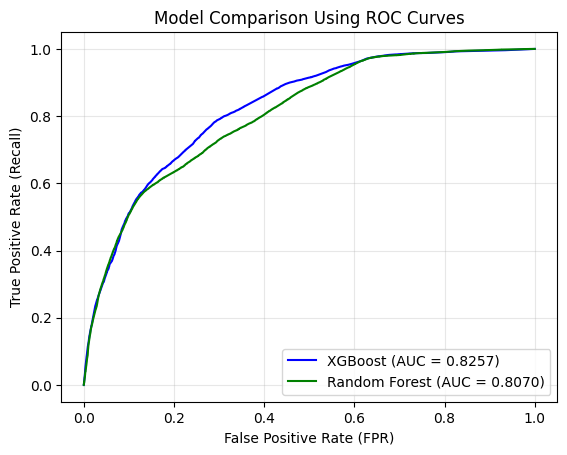

In [16]:
# False Positive Rate and True Positive Rate
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

auc_xgb = roc_auc_score(y_test, y_probs_xgb)
auc_rf = roc_auc_score(y_test, y_probs_rf)

# ROC Curves
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {auc_rf:.4f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Model Comparison Using ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Feature Importance

#### Radom Forest

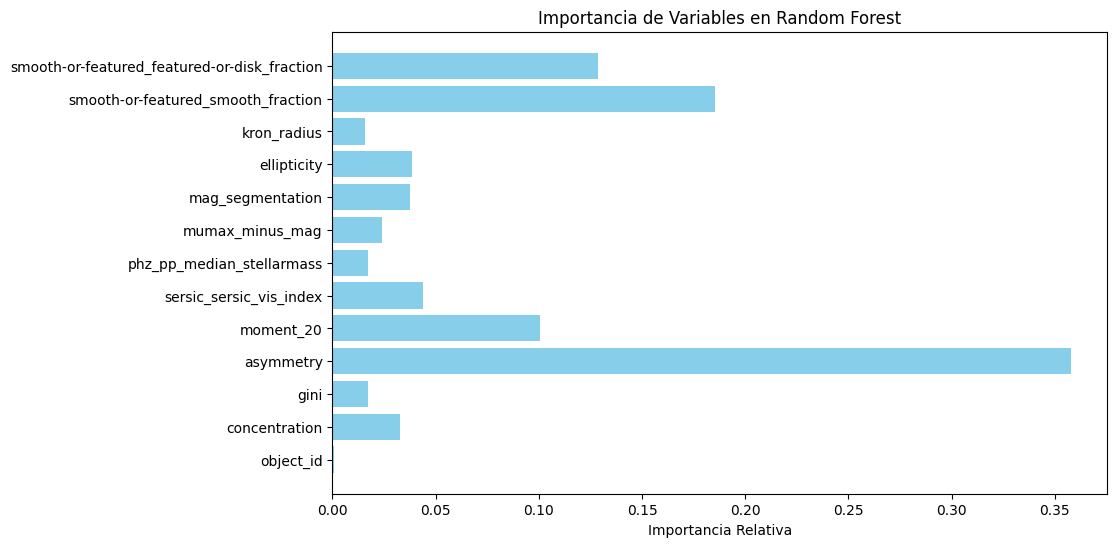

In [17]:
### Random forest ###
importances_rf = rf.feature_importances_
feature_names = X.columns

# Graph
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_rf, color='skyblue')
plt.xlabel('Importancia Relativa')
plt.title('Importancia de Variables en Random Forest')
plt.show()

#### XGBoost

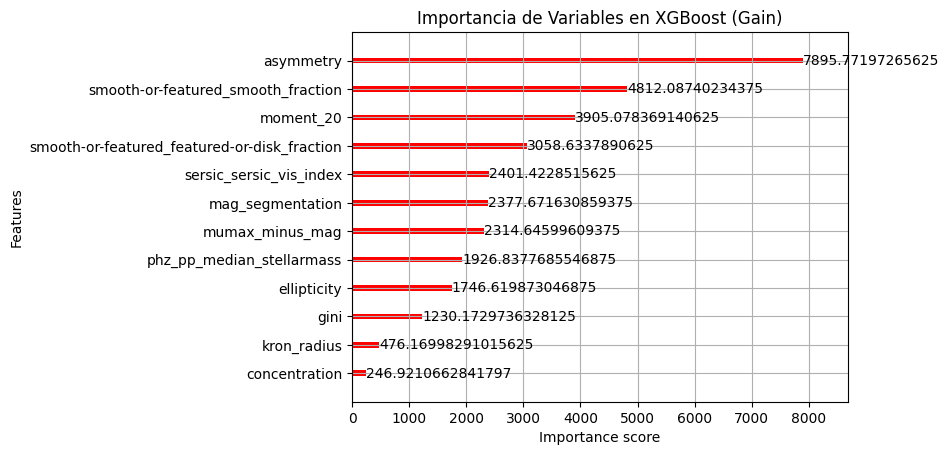

In [19]:
### XGBoost ###
plot_importance(xgb, importance_type='gain', color='red')
plt.title('Importancia de Variables en XGBoost (Gain)')
plt.show()

In general terms, both models identify the same variables as the most relevant for detecting galaxy mergers.